# EDA Times series

Reading Times Series Forecasting in Python by @Marco Peixeiro

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns


import ipywidgets as widgets

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from datetime import date
import holidays
import calendar
import dateutil.easter as easter

from collections import defaultdict
le = defaultdict(LabelEncoder)

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(12, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import gc
import os
import math
import random

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Admin
ID = "row_id"            # Id id x X index
INPUT = "../input/tabular-playground-series-jan-2022"

# time series data common new feature
DATE = "date"
YEAR = "year"
QUARTER = "quarter"
MONTH = "month"
WEEK = "week"
DAY = "day"
DAYOFYEAR = "dayofyear"
WEEKOFYEAR = "weekofyear"
DAYOFMONTH = "dayofMonth"
DAYOFWEEK = "dayofweek"
WEEKDAY = "weekday"

In [3]:
from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", parse_dates=[DATE],
                    usecols=['date', 'country', 'store', 'product', 'num_sold'],
                    dtype={
                        'country': 'category',
                        'store': 'category',
                        'product': 'category',
                        'num_sold': 'float64',
                    },
                    infer_datetime_format=True,)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID, parse_dates=[DATE])
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    df_train[DATE] = pd.to_datetime(df_train[DATE])
    df_test[DATE] = pd.to_datetime(df_test[DATE])
    return df_train, df_test, column_y


In [4]:
def process_data(df_train, df_test):
    # Preprocessing
    if FEATURE_ENGINEERING:
        df_train = feature_engineer(df_train)
        df_test = feature_engineer(df_test)

    return df_train, df_test

# Load Data
The first step is to gather the data. Then, we test for stationarity. In the event
where our series is not stationary, we apply transformations, such as differencing, until the
series is stationary. Then, we plot the ACF and look for significant autocorrelation
coefficients. In the case of a random walk, we will not see significant coefficients after lag 0.
On the other hand, if we see significant coefficients, then we must check if they become
abruptly non-significant after some lag q . If that is the case, then we know that we have a
moving average process of order q . Otherwise, we must follow a different set of steps to
discover the underlying process of our time series.

In [5]:
train_df, test_df, column_y = load_data()

In [6]:
train_df

,date,country,store,product,num_sold
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0
...,...,...,...,...,...
26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823.0
26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250.0
26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004.0
26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441.0


In [7]:
df = train_df.groupby(['country', 'store', 'product', 'date']).mean().unstack(['country', 'store', 'product']) #.loc['2015']

In [8]:
train_subset = train_df[(train_df.country == 'Norway') & (train_df.store == 'KaggleMart') & (train_df['product'] == 'Kaggle Hat')].copy()

## Plot of subset year 2015-2018 Norway KaggleMart Kaggle Hat

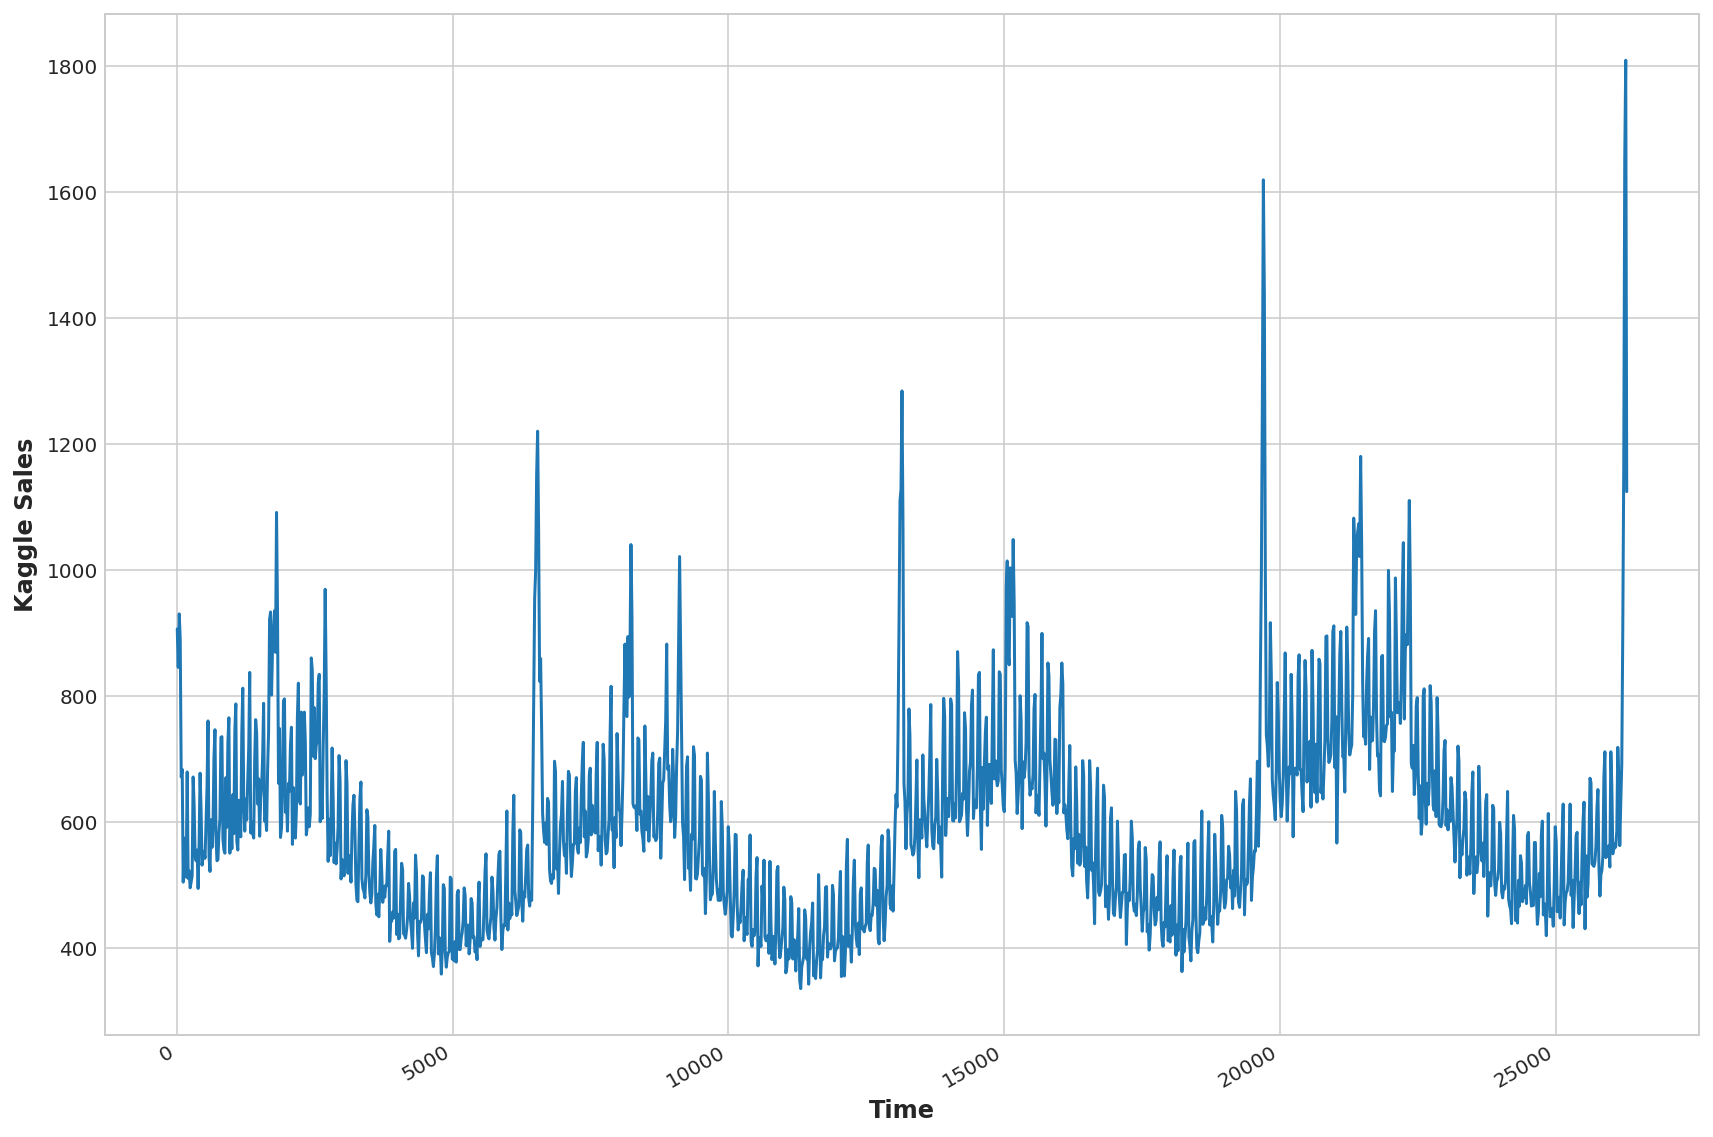

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_subset[column_y])
ax.set_xlabel('Time')
ax.set_ylabel('Kaggle Sales')
fig.autofmt_xdate()
plt.tight_layout()

In [10]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(train_df[column_y])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -9.00826282394742
p-value: 6.225906348503677e-15


The next step is to test for stationarity. We intuitively know that the series is not stationary
since there is an observable trend till 2018. Still, we will use the ADF test to make
sure. Again, we use the adfuller function from the statsmodels library and extract the ADF
statistic and p-value. If the ADF statistic is a large negative number and the p-value is
smaller than 0.05, then our series is stationary. Otherwise, we must apply transformations.

In [11]:
ADF_result = adfuller(train_subset[column_y])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.509110926525077
p-value: 0.11327324657223364


This results in an ADF statistic of -2.5 and a p-value of 0.11. Here, the ADF statistic is not a
large negative number and the p-value is greater than 0.05. Therefore, our time series is not
stationary and we must apply transformations to make it stationary.
In order to make our series stationary, we will try to stabilize the trend by applying a
first-order differencing. We can do so by using the diff method from the numpy library.
Remember that this method takes in a parameter n that specifies the order of differencing.
In this case, because it is a first-order differencing, n will be equal to 1.

In [12]:
import numpy as np
kaggle_2015_sales_diff = np.diff(train_subset[column_y], n=1)

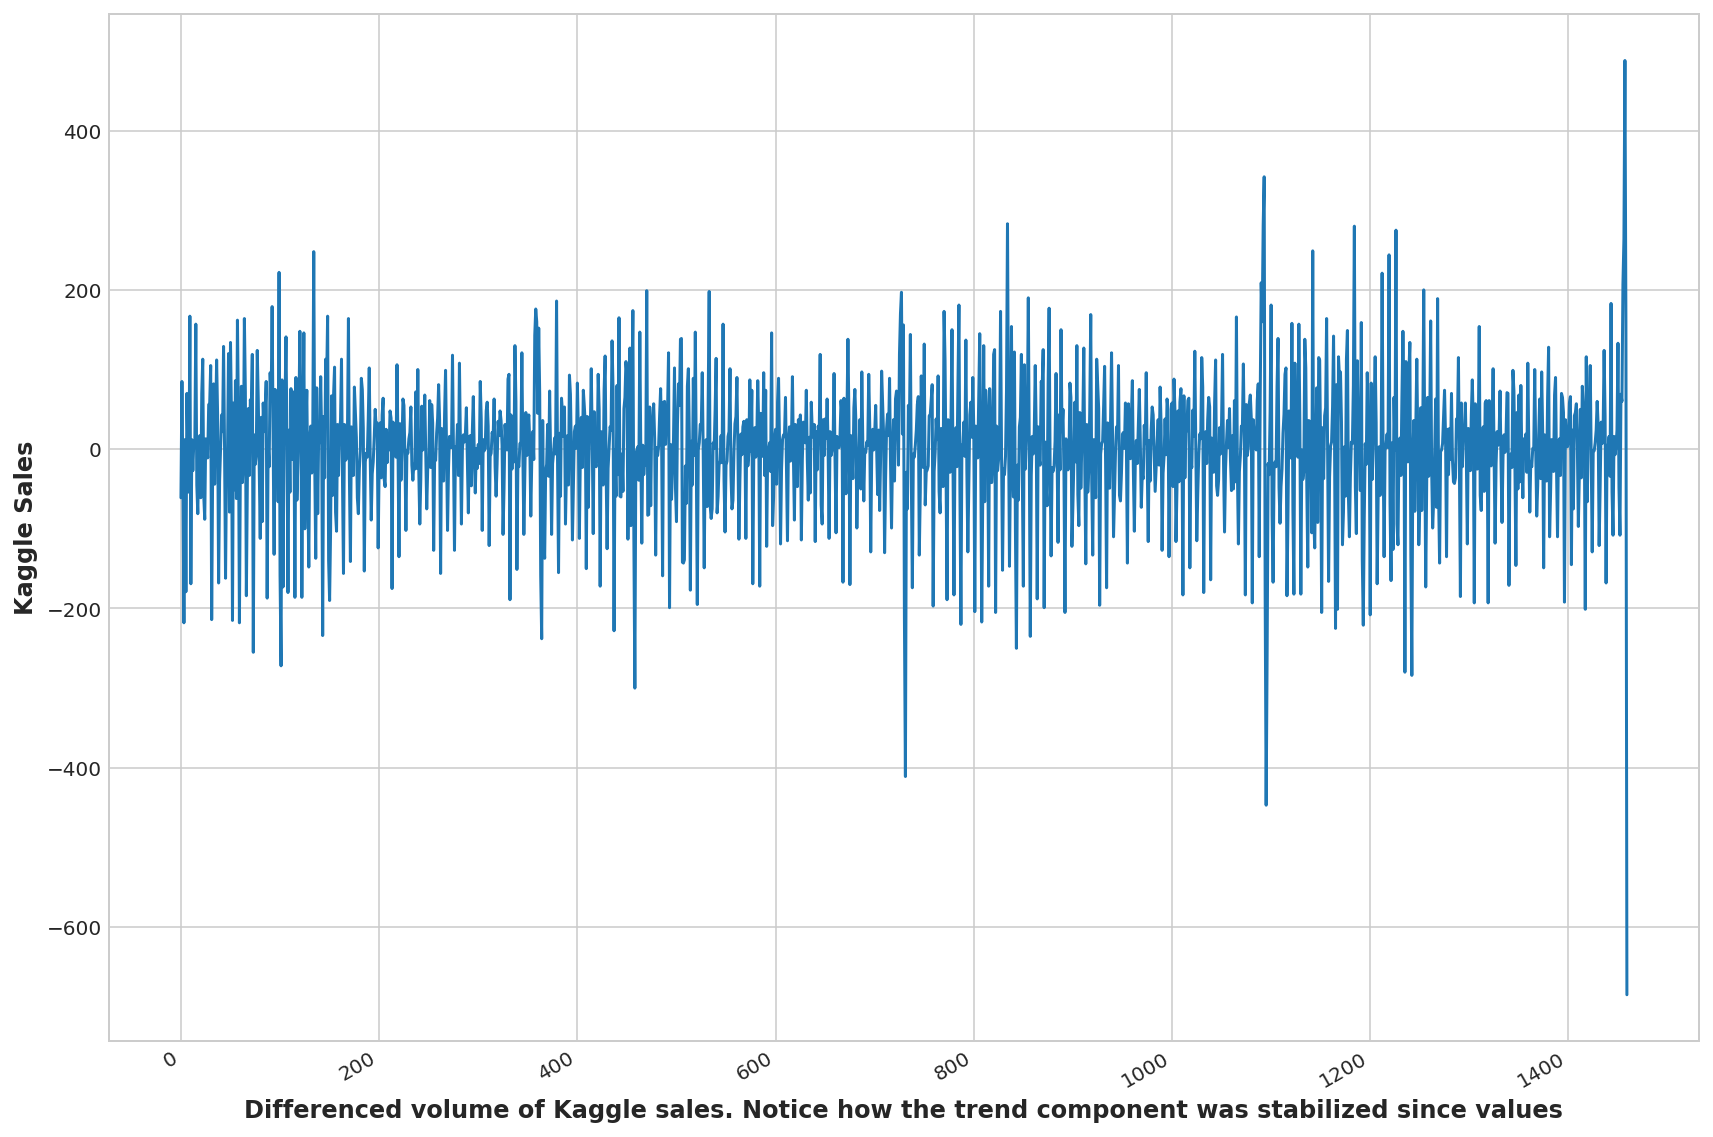

In [13]:
fig, ax = plt.subplots()
ax.plot(kaggle_2015_sales_diff)
ax.set_xlabel('Differenced volume of Kaggle sales. Notice how the trend component was stabilized since values')
ax.set_ylabel('Kaggle Sales')
fig.autofmt_xdate()
plt.tight_layout()

With a transformation applied to our series, we can test for stationarity again using the ADF
test. This time, make sure to run the test on the differenced data stored in the
*kaggle_2015_sales_diff* variable.

In [14]:
ADF_result = adfuller(kaggle_2015_sales_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.520481753221445
p-value: 9.71199558468163e-19


This gives an ADF statistic of -10.5 and a p-value of 9.7 × 10 −19 . Therefore, with a large
negative ADF statistic and a p-value much smaller than 0.05, we can say that our series is
stationary.
Our next step is to plot the autocorrelation function. The statsmodels library
conveniently includes the plot_acf function for us. We simply pass in our differenced series
and specify the number of lags in the lags parameter. Remember that the number of lags
determines the range of values on the x-axis.

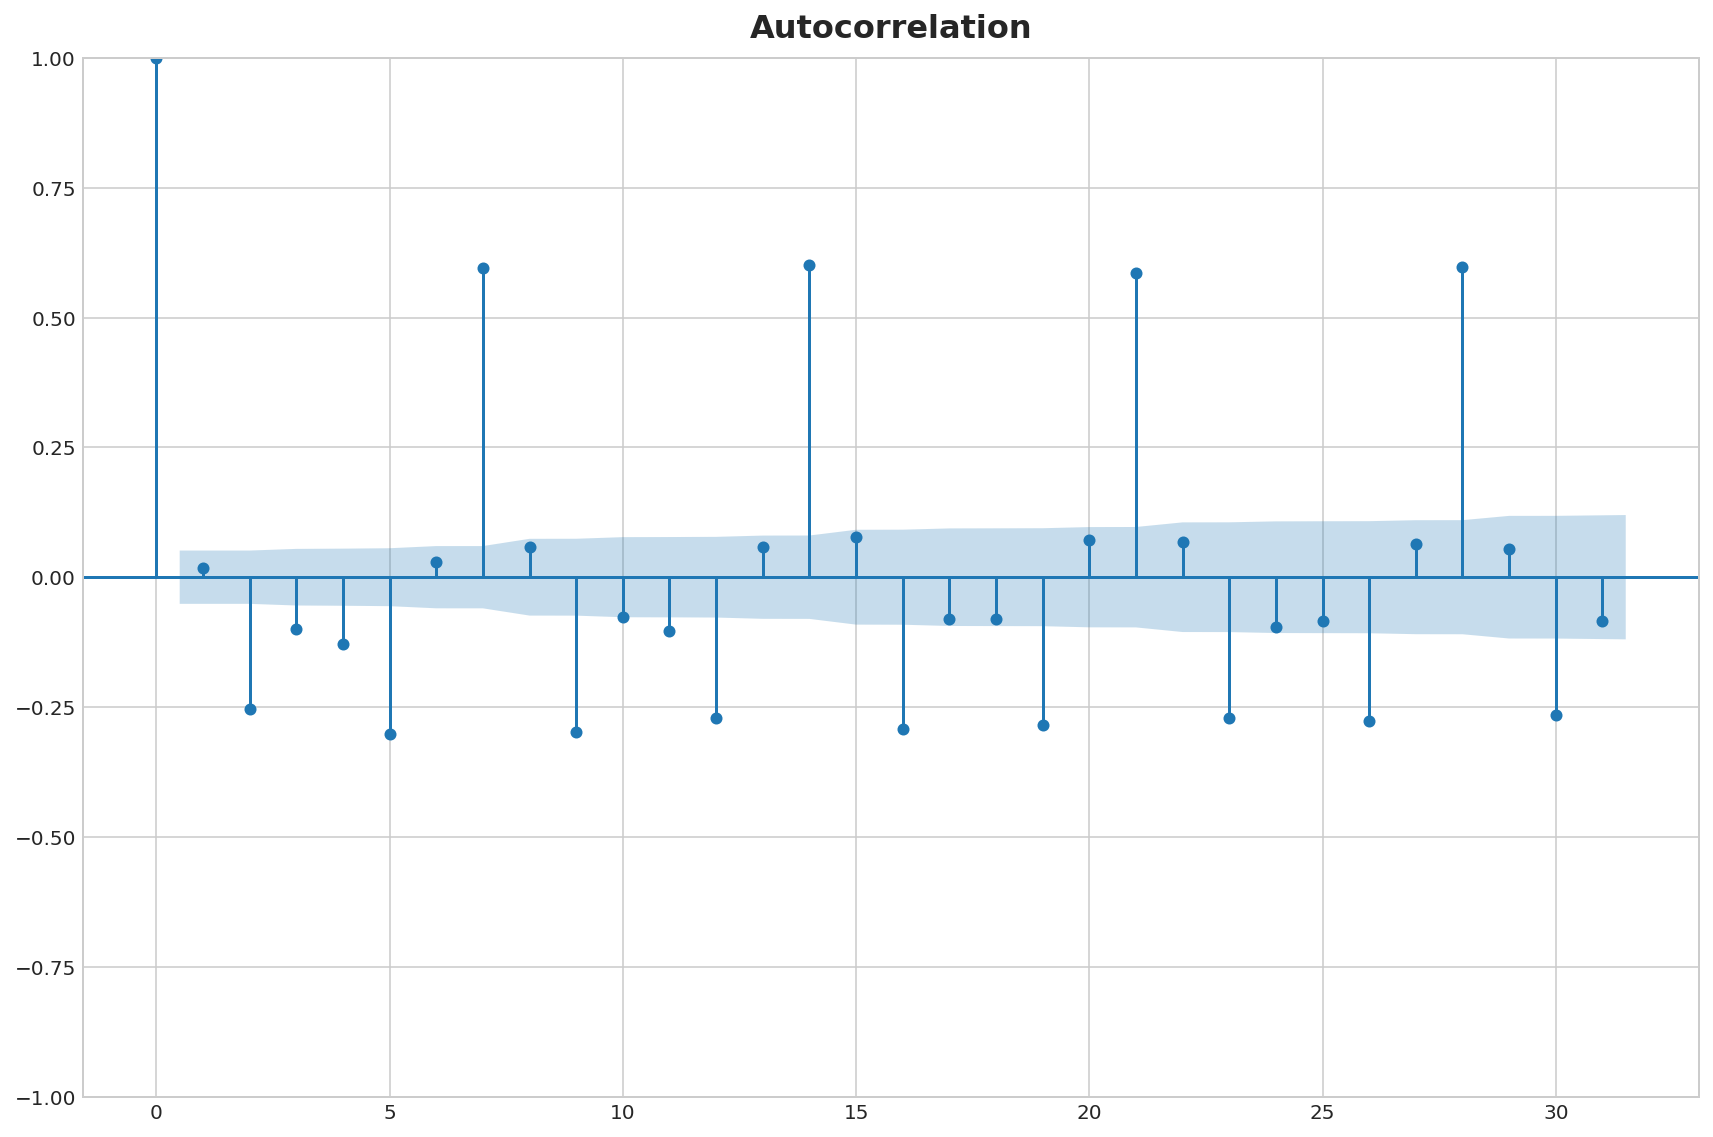

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(kaggle_2015_sales_diff, lags=31);
plt.tight_layout()

- We notice that there are significant coefficients after lag 0. In fact, they are significant up until lag 30. 
- Notice the coefficients 7, 14, 21, 28(weekly, weekend). 
- Negative coefficients on weekdays Monday-Thursday.
- Non-significant coefficients remain in the shaded area of the plot.

Since we have significant autocorrelation coefficients inteval of 7, this means that we have
a stationary moving average process of order 7. Therefore, we can use a 7-order
moving average model, or MA(7) model, to forecast our stationary time series.

In [16]:
df_diff = pd.DataFrame({'kaggle_2015_sales_diff': kaggle_2015_sales_diff})
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]
print(len(train))
print(len(test))

1314
146


For the forecast horizon the moving average model bring in a particularity. The MA(q) model
does not allow us to forecast 50 steps into future in one shot. Remember that the moving
average model is linearly dependent on past error terms. Those terms are not observed in
the dataset and must therefore be recursively estimated. This means that for an MA(q)
model, we can only forecast q steps into the future. Any prediction made beyond that point
will not have past error terms and the model will only predict the mean. Therefore, there is
no added value in forecasting beyond q steps into the future because the predictions will fall
flat, as only the mean is returned, which is equivalent to a baseline model.

# Opps, this is for year 2019 365 days one-shot.
I stop here for now. :S